***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
#     m['Features']=m['Features'].str.replace("dom_function_","")
#     m['Features']=m['Features'].str.replace("js_function_","")
#     m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
#     m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

In [3]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [4]:
columns=['http_header_cache-control_set_max-age',
 'http_header_cache-control_set_must-revalidate',
 'http_header_cache-control_set_no-cache',
 'http_header_cache-control_set_no-store',
 'http_header_cache-control_set_private',
 'http_header_cache-control_set_public',
 'http_header_content-encoding_gzip',
 'http_header_content-language_text/html',
 'http_header_content-length',
 'http_header_server_apache',
 'http_header_server_nginx','Target','domain']

In [5]:
df=pd.read_csv('Modified_http.csv',usecols=columns)

df.rename(columns={'Malicious':'Target'},inplace=True)
df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]
df.drop(cookies,axis=1,inplace=True)

df=df[df['domain']!=0]

df.sort_values(by='Target',inplace=True,ascending=False)
df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
df.set_index(['domain'],drop=True,inplace=True)
print("Shape of our dataset:",df.shape)

Shape of our dataset: (45856, 12)


In [6]:
df.Target.value_counts()

0    39835
1     6021
Name: Target, dtype: int64

In [7]:
train=df.iloc[:36684,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

In [8]:
test=df.iloc[36684:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [9]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [10]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns[:-2])
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.891042416312
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31711   142    31853
True        3855   976     4831
__all__    35566  1118    36684

Accuracy of the model for test data is: 0.892935019625
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7936    46     7982
True         936   254     1190
__all__     8872   300     9172



Logistic Regression
Accuracy of the model for training data is: 0.873105441064
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29372  2481    31853
True        2174  2657     4831
__all__    31546  5138    36684

Accuracy of the model for test data is: 0.873746184038
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7364   618     7982
True         540   650     1190
__all__     7904  1268     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.905680950823
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28861  2992    31853
True         468  4363     4831
__all__    29329  7355    36684

Accuracy of the model for test data is: 0.898604448321
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7211   771     7982
True         159  1031     1190
__all__     7370  1802     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.881937629484
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29160  2693    31853
True        1638  3193     4831
__all__    30798  5886    36684

Accuracy of the model for test data is: 0.886066288705
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7321   661     7982
True         384   806     1190
__all__     7705  1467     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.894204557845
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29350  2503    31853
True        1378  3453     4831
__all__    30728  5956    36684

Accuracy of the model for test data is: 0.894352376799
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7349   633     7982
True         336   854     1190
__all__     7685  1487     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.907234761749
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28877  2976    31853
True         427  4404     4831
__all__    29304  7380    36684

Accuracy of the model for test data is: 0.897841255997
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7197   785     7982
True         152  1038     1190
__all__     7349  1823     9172



Bagging Classifier
Accuracy of the model for training data is: 0.906008068913
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28861  2992    31853
True         456  4375     4831
__all__    29317  7367    36684

Accuracy of the model for test data is: 0.901003052769
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7221   761     7982
True         147  1043     1190
__all__     7368  1804     9172



Neural Network-1
The accuracy of the model on training data is: 0.883409660888


Predicted  False  True  __all__
Actual                         
False      28585  3268    31853
True        1009  3822     4831
__all__    29594  7090    36684

The accuracy of the model on test data is: 0.888573920628


Predicted  False  True  __all__
Actual                         
False       7206   776     7982
True         246   944     1190
__all__     7452  1720     9172

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [11]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [12]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.891042,976.0,31711.0,142.0,3855.0,0.004458,0.797971
LogisticRegression,0.873105,2657.0,29372.0,2481.0,2174.0,0.077889,0.450010
RandomForestClassifier,0.905681,4363.0,28861.0,2992.0,468.0,0.093931,0.096874
AdaBoostClassifier,0.881938,3193.0,29160.0,2693.0,1638.0,0.084545,0.339060
GradientBoostingClassifier,0.894205,3453.0,29350.0,2503.0,1378.0,0.078580,0.285241
ExtraTreeClassifier,0.907235,4404.0,28877.0,2976.0,427.0,0.093429,0.088387
BaggingClassifier,0.906008,4375.0,28861.0,2992.0,456.0,0.093931,0.094390
Neural Network-1,0.883410,3822.0,28585.0,3268.0,1009.0,0.102596,0.208859


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.892935,254.0,7936.0,46.0,936.0,0.005763,0.786555,0.603841,0.392336
LogisticRegression,0.873746,650.0,7364.0,618.0,540.0,0.077424,0.453782,0.734397,0.456382
RandomForestClassifier,0.898604,1031.0,7211.0,771.0,159.0,0.096592,0.133613,0.884897,0.651018
AdaBoostClassifier,0.886066,806.0,7321.0,661.0,384.0,0.082811,0.322689,0.797250,0.544979
GradientBoostingClassifier,0.894352,854.0,7349.0,633.0,336.0,0.079303,0.282353,0.819172,0.581978
ExtraTreeClassifier,0.897841,1038.0,7197.0,785.0,152.0,0.098346,0.127731,0.886961,0.651658
BaggingClassifier,0.901003,1043.0,7221.0,761.0,147.0,0.095340,0.123529,0.890566,0.660329
Neural Network-1,0.888574,944.0,7206.0,776.0,246.0,0.097219,0.206723,0.890566,0.599204


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [13]:
feat_impt_plot(np.average(feat_imp,axis=0),columns[:-2])

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [14]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [15]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [16]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns[:-2])
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.618607352526
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31226   627    31853
True       23670  8183    31853
__all__    54896  8810    63706

Accuracy of the model for test data is: 0.879197557785
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7768   214     7982
True         894   296     1190
__all__     8662   510     9172



Logistic Regression
Accuracy of the model for training data is: 0.827473079459
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26109   5744    31853
True        5247  26606    31853
__all__    31356  32350    63706

Accuracy of the model for test data is: 0.822721325774
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6549  1433     7982
True         193   997     1190
__all__     6742  2430     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.917213449283
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28651   3202    31853
True        2072  29781    31853
__all__    30723  32983    63706

Accuracy of the model for test data is: 0.88508504143
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7051   931     7982
True         123  1067     1190
__all__     7174  1998     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.855037202147
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      26154   5699    31853
True        3536  28317    31853
__all__    29690  34016    63706

Accuracy of the model for test data is: 0.829153946795
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6555  1427     7982
True         140  1050     1190
__all__     6695  2477     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.880639186262
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      27426   4427    31853
True        3177  28676    31853
__all__    30603  33103    63706

Accuracy of the model for test data is: 0.867640645443
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6889  1093     7982
True         121  1069     1190
__all__     7010  2162     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.920274385458
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28696   3157    31853
True        1922  29931    31853
__all__    30618  33088    63706

Accuracy of the model for test data is: 0.883231574357
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7033   949     7982
True         122  1068     1190
__all__     7155  2017     9172



Bagging Classifier
Accuracy of the model for training data is: 0.916962295545
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      28653   3200    31853
True        2090  29763    31853
__all__    30743  32963    63706

Accuracy of the model for test data is: 0.883013519407
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7030   952     7982
True         121  1069     1190
__all__     7151  2021     9172



Neural Network-1
The accuracy of the model on training data is: 0.884092550156


Predicted  False   True  __all__
Actual                          
False      27817   4036    31853
True        3348  28505    31853
__all__    31165  32541    63706

The accuracy of the model on test data is: 0.87887047536


Predicted  False  True  __all__
Actual                         
False       7002   980     7982
True         131  1059     1190
__all__     7133  2039     9172

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [17]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [18]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.618607,8183.0,31226.0,627.0,23670.0,0.019684,0.743101
LogisticRegression,0.827473,26606.0,26109.0,5744.0,5247.0,0.180328,0.164725
RandomForestClassifier,0.917213,29781.0,28651.0,3202.0,2072.0,0.100524,0.065049
AdaBoostClassifier,0.855037,28317.0,26154.0,5699.0,3536.0,0.178916,0.111010
GradientBoostingClassifier,0.880639,28676.0,27426.0,4427.0,3177.0,0.138982,0.099739
ExtraTreeClassifier,0.920274,29931.0,28696.0,3157.0,1922.0,0.099112,0.060340
BaggingClassifier,0.916962,29763.0,28653.0,3200.0,2090.0,0.100461,0.065614
Neural Network-1,0.884093,28505.0,27817.0,4036.0,3348.0,0.126707,0.105108


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.879198,296.0,7768.0,214.0,894.0,0.026810,0.751261,0.610965,0.325424
LogisticRegression,0.822721,997.0,6549.0,1433.0,193.0,0.179529,0.162185,0.829143,0.501241
RandomForestClassifier,0.885085,1067.0,7051.0,931.0,123.0,0.116637,0.103361,0.890001,0.634960
AdaBoostClassifier,0.829154,1050.0,6555.0,1427.0,140.0,0.178777,0.117647,0.851788,0.532478
GradientBoostingClassifier,0.867641,1069.0,6889.0,1093.0,121.0,0.136933,0.101681,0.880693,0.602764
ExtraTreeClassifier,0.883232,1068.0,7033.0,949.0,122.0,0.118893,0.102521,0.889293,0.631653
BaggingClassifier,0.883014,1069.0,7030.0,952.0,121.0,0.119268,0.101681,0.889525,0.631580
Neural Network-1,0.878870,1059.0,7002.0,980.0,131.0,0.122776,0.110084,0.889525,0.619953


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [19]:
feat_impt_plot(np.average(feat_imp,axis=0),columns[:-2])

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [20]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns[:-2]]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (9662, 11)


In [21]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [22]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns[:-2])
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.597805837301
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4718   113     4831
True        3773  1058     4831
__all__     8491  1171     9662

Accuracy of the model for test data is: 0.87112952464
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7725   257     7982
True         925   265     1190
__all__     8650   522     9172



Logistic Regression
Accuracy of the model for training data is: 0.830987373215
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3993   838     4831
True         795  4036     4831
__all__     4788  4874     9662

Accuracy of the model for test data is: 0.823593545573
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6554  1428     7982
True         190  1000     1190
__all__     6744  2428     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.914820948044
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4352   479     4831
True         344  4487     4831
__all__     4696  4966     9662

Accuracy of the model for test data is: 0.875163541212
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6952  1030     7982
True         115  1075     1190
__all__     7067  2105     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.846719105775
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4017   814     4831
True         667  4164     4831
__all__     4684  4978     9662

Accuracy of the model for test data is: 0.831661578718
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6612  1370     7982
True         174  1016     1190
__all__     6786  2386     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.88273649348
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4165   666     4831
True         467  4364     4831
__all__     4632  5030     9662

Accuracy of the model for test data is: 0.862298299171
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6833  1149     7982
True         114  1076     1190
__all__     6947  2225     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.918857379425
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4366   465     4831
True         319  4512     4831
__all__     4685  4977     9662

Accuracy of the model for test data is: 0.873310074139
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6937  1045     7982
True         117  1073     1190
__all__     7054  2118     9172



Bagging Classifier
Accuracy of the model for training data is: 0.915338439247
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4346   485     4831
True         333  4498     4831
__all__     4679  4983     9662

Accuracy of the model for test data is: 0.875381596162
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6960  1022     7982
True         121  1069     1190
__all__     7081  2091     9172



Neural Network-1
The accuracy of the model on training data is: 0.881701511099


Predicted  False  True  __all__
Actual                         
False       4248   583     4831
True         560  4271     4831
__all__     4808  4854     9662

The accuracy of the model on test data is: 0.878761447885


Predicted  False  True  __all__
Actual                         
False       7007   975     7982
True         137  1053     1190
__all__     7144  2028     9172

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [23]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [24]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.597806,1058.0,4718.0,113.0,3773.0,0.023391,0.780998
LogisticRegression,0.830987,4036.0,3993.0,838.0,795.0,0.173463,0.164562
RandomForestClassifier,0.914821,4487.0,4352.0,479.0,344.0,0.099151,0.071207
AdaBoostClassifier,0.846719,4164.0,4017.0,814.0,667.0,0.168495,0.138067
GradientBoostingClassifier,0.882736,4364.0,4165.0,666.0,467.0,0.137860,0.096667
ExtraTreeClassifier,0.918857,4512.0,4366.0,465.0,319.0,0.096253,0.066032
BaggingClassifier,0.915338,4498.0,4346.0,485.0,333.0,0.100393,0.068930
Neural Network-1,0.881702,4271.0,4248.0,583.0,560.0,0.120679,0.115918


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.871130,265.0,7725.0,257.0,925.0,0.032197,0.777311,0.595246,0.276288
LogisticRegression,0.823594,1000.0,6554.0,1428.0,190.0,0.178903,0.159664,0.830717,0.503770
RandomForestClassifier,0.875164,1075.0,6952.0,1030.0,115.0,0.129040,0.096639,0.887161,0.618738
AdaBoostClassifier,0.831662,1016.0,6612.0,1370.0,174.0,0.171636,0.146218,0.841073,0.522473
GradientBoostingClassifier,0.862298,1076.0,6833.0,1149.0,114.0,0.143949,0.095798,0.880126,0.595969
ExtraTreeClassifier,0.873310,1073.0,6937.0,1045.0,117.0,0.130920,0.098319,0.885381,0.614566
BaggingClassifier,0.875382,1069.0,6960.0,1022.0,121.0,0.128038,0.101681,0.885141,0.616956
Neural Network-1,0.878761,1053.0,7007.0,975.0,137.0,0.122150,0.115126,0.885141,0.617578


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [25]:
feat_impt_plot(np.average(feat_imp,axis=0),columns[:-2])

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [26]:
df.reset_index(inplace=True)
columns.remove('Target')
df_min=df[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 231 features
EntitySet scattered to workers in 4.179 seconds
Elapsed: 00:01 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [27]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [28]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [29]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [30]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [31]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [32]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [33]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [34]:
columns=feature_selection_df[feature_selection_df.Total>=3]['Feature'].values

In [35]:
fs=fs.reindex(df.index.values)
train=fs.iloc[:36684]
train_Y=train.Target.values
train_X=train[columns].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[36684:]
test_Y=test.Target.values
test_X=test[columns]

scaled_X_test=scaler.transform(test_X)

In [36]:
print('Features we will be using:\n')
display(columns)

Features we will be using:



array([ 'http_header_content-language_text/html / http_header_content-encoding_gzip',
       'http_header_content-language_text/html + http_header_server_nginx',
       'http_header_content-encoding_gzip / http_header_content-length',
       'http_header_content-encoding_gzip + http_header_content-language_text/html',
       'http_header_content-encoding_gzip * http_header_content-language_text/html',
       'http_header_content-encoding_gzip',
       'http_header_cache-control_set_private + http_header_content-encoding_gzip',
       'http_header_cache-control_set_no-cache + http_header_content-language_text/html',
       'http_header_cache-control_set_no-cache + http_header_content-encoding_gzip',
       'http_header_server_nginx / http_header_content-language_text/html',
       'http_header_server_nginx / http_header_cache-control_set_must-revalidate',
       'http_header_server_nginx / http_header_cache-control_set_max-age',
       'http_header_content-language_text/html / http_head

In [37]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [38]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.883055282957
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29291  2562    31853
True        1728  3103     4831
__all__    31019  5665    36684

Accuracy of the model for test data is: 0.881705189708
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7338   644     7982
True         441   749     1190
__all__     7779  1393     9172



Logistic Regression
Accuracy of the model for training data is: 0.873677897721
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29115  2738    31853
True        1896  2935     4831
__all__    31011  5673    36684

Accuracy of the model for test data is: 0.87156563454
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7287   695     7982
True         483   707     1190
__all__     7770  1402     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.892950605168
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29219  2634    31853
True        1293  3538     4831
__all__    30512  6172    36684

Accuracy of the model for test data is: 0.887156563454
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7284   698     7982
True         337   853     1190
__all__     7621  1551     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.87397775597
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29125  2728    31853
True        1895  2936     4831
__all__    31020  5664    36684

Accuracy of the model for test data is: 0.871892716965
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7297   685     7982
True         490   700     1190
__all__     7787  1385     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.888534510958
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29254  2599    31853
True        1490  3341     4831
__all__    30744  5940    36684

Accuracy of the model for test data is: 0.887374618404
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7323   659     7982
True         374   816     1190
__all__     7697  1475     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.893659361029
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29234  2619    31853
True        1282  3549     4831
__all__    30516  6168    36684

Accuracy of the model for test data is: 0.887374618404
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7285   697     7982
True         336   854     1190
__all__     7621  1551     9172



Bagging Classifier
Accuracy of the model for training data is: 0.892923345328
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29218  2635    31853
True        1293  3538     4831
__all__    30511  6173    36684

Accuracy of the model for test data is: 0.888464893153
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7298   684     7982
True         339   851     1190
__all__     7637  1535     9172



Neural Network-1
The accuracy of the model on training data is: 0.889188747144


Predicted  False  True  __all__
Actual                         
False      29212  2641    31853
True        1424  3407     4831
__all__    30636  6048    36684

The accuracy of the model on test data is: 0.888901003053


Predicted  False  True  __all__
Actual                         
False       7314   668     7982
True         351   839     1190
__all__     7665  1507     9172

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [39]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [40]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.883055,3103.0,29291.0,2562.0,1728.0,0.080432,0.357690
LogisticRegression,0.873678,2935.0,29115.0,2738.0,1896.0,0.085957,0.392465
RandomForestClassifier,0.892951,3538.0,29219.0,2634.0,1293.0,0.082692,0.267646
AdaBoostClassifier,0.873978,2936.0,29125.0,2728.0,1895.0,0.085643,0.392258
GradientBoostingClassifier,0.888535,3341.0,29254.0,2599.0,1490.0,0.081594,0.308425
ExtraTreeClassifier,0.893659,3549.0,29234.0,2619.0,1282.0,0.082221,0.265369
BaggingClassifier,0.892923,3538.0,29218.0,2635.0,1293.0,0.082724,0.267646
Neural Network-1,0.889189,3407.0,29212.0,2641.0,1424.0,0.082912,0.294763


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.881705,749.0,7338.0,644.0,441.0,0.080682,0.370588,0.774365,0.513749
LogisticRegression,0.871566,707.0,7287.0,695.0,483.0,0.087071,0.405882,0.753523,0.473470
RandomForestClassifier,0.887157,853.0,7284.0,698.0,337.0,0.087447,0.283193,0.814680,0.564179
AdaBoostClassifier,0.871893,700.0,7297.0,685.0,490.0,0.085818,0.411765,0.751209,0.471502
GradientBoostingClassifier,0.887375,816.0,7323.0,659.0,374.0,0.082561,0.314286,0.801577,0.551697
ExtraTreeClassifier,0.887375,854.0,7285.0,697.0,336.0,0.087321,0.282353,0.815163,0.565044
BaggingClassifier,0.888465,851.0,7298.0,684.0,339.0,0.085693,0.284874,0.814717,0.566583
Neural Network-1,0.888901,839.0,7314.0,668.0,351.0,0.083688,0.294958,0.814717,0.563450


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [41]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [42]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

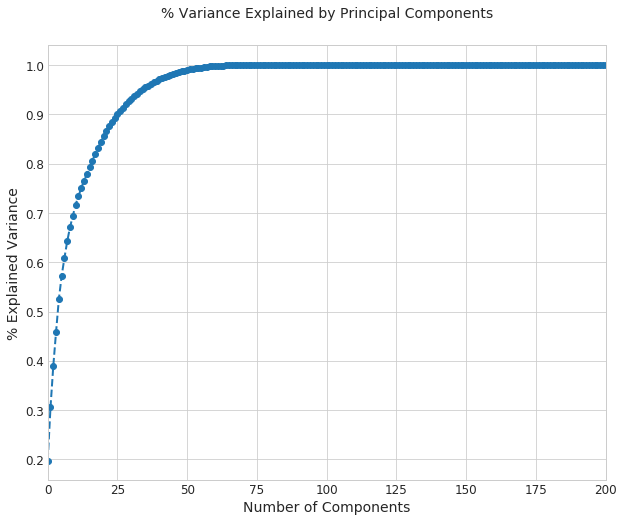

In [43]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [44]:
np.where(np.cumsum(pca.explained_variance_ratio_)>0.95)[0][0]

34

In [45]:
pca=PCA(n_components=34,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 34 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 34 components is: 0.946903958497


In [48]:
X_train=X_pca_21[:36684]
Y_train=fs.iloc[:36684]['Target'].values
X_test=X_pca_21[36684:]
Y_test=fs.iloc[36684:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [49]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,34).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.890715298223
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31065   788    31853
True        3221  1610     4831
__all__    34286  2398    36684

Accuracy of the model for test data is: 0.893153074575
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7792   190     7982
True         790   400     1190
__all__     8582   590     9172



Logistic Regression
Accuracy of the model for training data is: 0.876213062916
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      29214  2639    31853
True        1902  2929     4831
__all__    31116  5568    36684

Accuracy of the model for test data is: 0.875163541212
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7321   661     7982
True         484   706     1190
__all__     7805  1367     9172



RandomForest Classifier
Accuracy of the model for training data is: 0.905653690982
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28845  3008    31853
True         453  4378     4831
__all__    29298  7386    36684

Accuracy of the model for test data is: 0.899149585696
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7210   772     7982
True         153  1037     1190
__all__     7363  1809     9172



Adaoost Classifier
Accuracy of the model for training data is: 0.892214589467
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28743  3110    31853
True         844  3987     4831
__all__    29587  7097    36684

Accuracy of the model for test data is: 0.894461404274
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7230   752     7982
True         216   974     1190
__all__     7446  1726     9172



GradientBoosting Classifier
Accuracy of the model for training data is: 0.89842983317
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28846  3007    31853
True         719  4112     4831
__all__    29565  7119    36684

Accuracy of the model for test data is: 0.898386393371
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7245   737     7982
True         195   995     1190
__all__     7440  1732     9172



ExtraTree Classifier
Accuracy of the model for training data is: 0.907234761749
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28877  2976    31853
True         427  4404     4831
__all__    29304  7380    36684

Accuracy of the model for test data is: 0.897514173572
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7198   784     7982
True         156  1034     1190
__all__     7354  1818     9172



Bagging Classifier
Accuracy of the model for training data is: 0.90557191146
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      28855  2998    31853
True         466  4365     4831
__all__    29321  7363    36684

Accuracy of the model for test data is: 0.898386393371
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7204   778     7982
True         154  1036     1190
__all__     7358  1814     9172



Neural Network-1
The accuracy of the model on training data is: 0.891478573772


Predicted  False  True  __all__
Actual                         
False      29219  2634    31853
True        1347  3484     4831
__all__    30566  6118    36684

The accuracy of the model on test data is: 0.891844744876


Predicted  False  True  __all__
Actual                         
False       7328   654     7982
True         338   852     1190
__all__     7666  1506     9172

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [50]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [51]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.890715,1610.0,31065.0,788.0,3221.0,0.024739,0.666736
LogisticRegression,0.876213,2929.0,29214.0,2639.0,1902.0,0.082849,0.393707
RandomForestClassifier,0.905654,4378.0,28845.0,3008.0,453.0,0.094434,0.093769
AdaBoostClassifier,0.892215,3987.0,28743.0,3110.0,844.0,0.097636,0.174705
GradientBoostingClassifier,0.898430,4112.0,28846.0,3007.0,719.0,0.094402,0.148830
ExtraTreeClassifier,0.907235,4404.0,28877.0,2976.0,427.0,0.093429,0.088387
BaggingClassifier,0.905572,4365.0,28855.0,2998.0,466.0,0.094120,0.096460
Neural Network-1,0.891479,3484.0,29219.0,2634.0,1347.0,0.082692,0.278824


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.893153,400.0,7792.0,190.0,790.0,0.023804,0.663866,0.656165,0.427783
LogisticRegression,0.875164,706.0,7321.0,661.0,484.0,0.082811,0.406723,0.755233,0.481643
RandomForestClassifier,0.899150,1037.0,7210.0,772.0,153.0,0.096718,0.128571,0.887355,0.654218
AdaBoostClassifier,0.894461,974.0,7230.0,752.0,216.0,0.094212,0.181513,0.862138,0.622660
GradientBoostingClassifier,0.898386,995.0,7245.0,737.0,195.0,0.092333,0.163866,0.871901,0.638596
ExtraTreeClassifier,0.897514,1034.0,7198.0,784.0,156.0,0.098221,0.131092,0.885343,0.649604
BaggingClassifier,0.898386,1036.0,7204.0,778.0,154.0,0.097469,0.129412,0.886559,0.652194
Neural Network-1,0.891845,852.0,7328.0,654.0,338.0,0.081934,0.284034,0.886559,0.575100


In [52]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')